<a href="https://colab.research.google.com/github/niikun/ai_engineering_day3/blob/main/Week3_HomeWork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 宿題3週目

## モデルなど準備

In [1]:
!pip install -q --upgrade transformers
!pip install -q google-colab-selenium
!pip install -q bitsandbytes

In [2]:
!pip install langchain-community langchain_chroma langchain_openai

In [3]:
from huggingface_hub import notebook_login

notebook_login()

In [4]:
!pip install japanize_matplotlib

  Using cached japanize-matplotlib-1.1.3.tar.gz (4.1 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=5cd946d66653e14d1f391e21804bc80e727cb2752d767382c3d00791c7dd6f9e
  Stored in directory: /root/.cache/pip/wheels/da/a1/71/b8faeb93276fed10edffcca20746f1ef6f8d9e071eee8425fc
Successfully built japanize_matplotlib


In [5]:
# CUDAが利用可能ならGPUを、それ以外ならCPUをデバイスとして設定
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
import numpy as np
import random
random.seed(0)

### モデル Llama-3-8B-Instruct

In [7]:
from transformers import AutoModelForCausalLM,AutoTokenizer,BitsAndBytesConfig

model_name = "meta-llama/Meta-Llama-3-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=False,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=bnb_config,
    torch_dtype=torch.bfloat16
)

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

### Generate_output

In [8]:
def generate_output(query,system_prompt=None):

    if system_prompt is None:
        messages = [
            {"role":"user","content":query}
        ]
    else:
        messages = [
            {"role":"system","content":system_prompt},
            {"role":"user","content":query}
        ]
    input_ids = tokenizer.apply_chat_template(
        messages,
        # モデルに「ここからあなたが続きを書いてね」という合図（生成用プロンプト）を自動で最後に付け加えます。
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(model.device)

    # terminators は、モデルが「ここで文章を終わり」と判断するための「終端トークン」のIDをまとめたリスト。
    terminators = [
        # もともと用意されている「End Of Sequence（EOS）」トークンのID
        tokenizer.eos_token_id,
        # 独自に「End Of Turn（EOT）」などの特別な終端マーカー <|eot_id|> を定義している場合、その文字列を対応する数値IDに変換
        tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]

    outputs = model.generate(
        input_ids,
        max_new_tokens=256,
        eos_token_id=terminators,
        # False:greedy生成=最も確率の高い次のトークンを選ぶ。Trueの場合はランダムサンプリングを行いバリエーション出す
        do_sample=False,
    )
    response = outputs[0][input_ids.shape[-1]:]
    return tokenizer.decode(response,skip_special_tokens=True)

### evaluate_answer_accuracy

In [9]:
!pip install -U openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.0/662.0 kB 43.9 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.76.0
    Uninstalling openai-1.76.0:
      Successfully uninstalled openai-1.76.0


In [10]:
from openai import OpenAI
from google.colab import userdata
OPEN_AI_API_KEY = userdata.get("OPENAI_API_KEY")
client = OpenAI(api_key=OPEN_AI_API_KEY, max_retries=5, timeout=60)

def openai_generator(query):
    messages = [
        {
            "role":"user",
            "content":query
        }
    ]
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages
    )
    return response.choices[0].message.content

def evaluate_answer_accuracy(query, response, reference):

    template_accuracy1 = (
          "Instruction: You are a world class state of the art assistant for rating "
          "a User Answer given a Question. The Question is completely answered by the Reference Answer.\n"
          "Say 4, if User Answer is full contained and equivalent to Reference Answer"
          "in all terms, topics, numbers, metrics, dates and units.\n"
          "Say 2, if User Answer is partially contained and almost equivalent to Reference Answer"
          "in all terms, topics, numbers, metrics, dates and units.\n"
          "Say 0, if User Answer is not contained in Reference Answer or not accurate in all terms, topics,"
          "numbers, metrics, dates and units or the User Answer do not answer the question.\n"
          "Do not explain or justify your rating. Your rating must be only 4, 2 or 0 according to the instructions above.\n"
          "Even small discrepancies in meaning, terminology, directionality, or implication must result in a lower score. Only rate 4 if the User Answer is a complete and precise match to the Reference Answer in every aspect.\n"
          "### Question: {query}\n"
          "### {answer0}: {sentence_inference}\n"
          "### {answer1}: {sentence_true}\n"
          "The rating is:\n"
      )
    template_accuracy2 = (
          "I will rate the User Answer in comparison to the Reference Answer for a given Question.\n"
          "A rating of 4 indicates that the User Answer is entirely consistent with the Reference Answer, covering all aspects, topics, numbers, metrics, dates, and units.\n"
          "A rating of 2 signifies that the User Answer is mostly aligned with the Reference Answer, with minor discrepancies in some areas.\n"
          "A rating of 0 means that the User Answer is either inaccurate, incomplete, or unrelated to the Reference Answer, or it fails to address the Question.\n"
          "I will provide the rating without any explanation or justification, adhering to the following scale: 0 (no match), 2 (partial match), 4 (exact match).\n"
          "Even minor inconsistencies in meaning, terminology, emphasis, or factual detail should prevent a rating of 4. Only assign a 4 if the User Answer exactly and unambiguously matches the Reference Answer in every respect."
          "Do not explain or justify my rating. My rating must be only 4, 2 or 0 only.\n\n"
          "Question: {query}\n\n"
          "{answer0}: {sentence_inference}\n\n"
          "{answer1}: {sentence_true}\n\n"
          "Rating: "
      )

    score1 = openai_generator(
                template_accuracy1.format(
                      query=query,
                      answer0="User Answer",
                      answer1="Reference Answer",
                      sentence_inference=response,
                      sentence_true=reference,
                    )
                )
    try:
      score1 = int(score1)
    except:
      print("Failed")
      score1 = 0

    score2 = openai_generator(
                template_accuracy2.format(
                        query=query,
                        answer0="Reference Answer",
                        answer1="User Answer",
                        sentence_inference=reference,
                        sentence_true=response,
                    )
                  )

    try:
      score2 = int(score2)
    except:
      print("Failed")
      score2 = 0


    return (score1 + score2) / 2

## RAG準備

In [11]:
from sentence_transformers import SentenceTransformer

emb_model = SentenceTransformer("infly/inf-retriever-v1-1.5b", trust_remote_code=True)
# emb_model = SentenceTransformer("all-MiniLM-L6-v2", trust_remote_code=True)
emb_model.max_seq_length = 8192

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/284 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/19.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/55.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/918 [00:00<?, ?B/s]

modeling_qwen.py:   0%|          | 0.00/65.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/infly/inf-retriever-v1-1.5b:
- modeling_qwen.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

tokenization_qwen.py:   0%|          | 0.00/10.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/infly/inf-retriever-v1-1.5b:
- tokenization_qwen.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/370 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

### 2-1 Simple RAG

初期RAG実装（ベーシックアプローチ）:
- **分割方法:** 「。」（句点）で区切られた文単位でテキストを分割
- **検索手法:** シンプルな類似度ベースの検索でクエリに関連する文を抽出
- **制約条件:** モデルの入力トークン制限に収まるよう関連文のみを選択

In [12]:
def no_rag(query):
    system_prompt = "質問に回答してください。必ず「日本語で回答」すること。"
    question=f"[質問] {query}"
    return generate_output(query,system_prompt),None

In [13]:
def simple_rag(query,texts,topk=5):

    documents = [text.strip() for text in texts.split("。")]
    query = query

    query_embeddings = emb_model.encode([query],prompt_name="query")
    document_embeddings = emb_model.encode(documents)
    scores = (query_embeddings @ document_embeddings.T) * 100
    reference = "\n".join(["*" + documents[i] for i in scores.argsort()[0][::-1][:topk]])
    system_prompt = "質問に回答してください。必ず「日本語で回答」すること。また、与えられる資料を参考にして回答すること。"
    question = f"[参考資料]\n{reference}\n\n[質問] {query}"
    response = generate_output(question,system_prompt)
    return response,reference

### 2-2 Context RAG
* **前後文脈を含むチャンク化**:
  - 検索でマッチした文だけでなく、その前後の複数文も含めてチャンクとして取得
  - 具体的には、マッチした文を中心に前2文、後2文を含む計5文程度のチャンクを構成
  - この「文脈ウィンドウ」により、発言の背景情報や議論の流れが保持される

* **期待される効果**:
  - 講師の主張とその根拠の関係性を正確に把握できる
  - 概念の定義とその適用範囲を正しく理解できる

In [14]:
def context_rag(query,texts,topk=5):

    documents = [text.strip() for text in texts.split("。")]
    query = query

    query_embeddings = emb_model.encode([query],prompt_name="query")
    document_embeddings = emb_model.encode(documents)
    scores = (query_embeddings @ document_embeddings.T) * 100
    # 前後2つずつの文章を追加
    scores_vec = scores[0]
    topk_indices = np.argsort(scores_vec)[::-1][:topk]
    references = "\n".join(
    "*" + "。".join(
        documents[max(0, i-2) : min(i+3, len(documents))]
    )
    for i in topk_indices
    )
    system_prompt = "質問に回答してください。必ず「日本語で回答」すること。また、与えられる資料を参考にして回答すること。"
    question = f"[参考資料]\n{references}\n\n[質問] {query}"
    response = generate_output(question,system_prompt)
    return response,references

### 2-3 Rerankによる情報品質の向上
* **Rerank手法の導入**:
  - 第一段階: 従来通り基本的な検索アルゴリズムでtop-k個のドキュメントチャンクを取得
  - 第二段階: 取得したチャンクに対してLLMを活用した高度な関連性評価を実施
  - 関連性スコアに基づいてランク付けし、真に関連性の高いチャンクのみを選出

In [15]:
def rerank_rag(query, texts, topk=5):
    # 文ごとに分割して空要素を除去
    documents = [sent.strip() for sent in texts.split("。") if sent.strip()]

    # 埋め込みとスコア計算
    query_embeddings = emb_model.encode([query], prompt_name="query")
    document_embeddings  = emb_model.encode(documents)
    scores = (query_embeddings @ document_embeddings.T).flatten() * 100

    # 上位 topk のインデックス
    topk_indices = np.argsort(scores)[::-1][:topk]

    # 前後2文ずつをくっつけてリファレンス候補を作成（先頭に * をつける）
    refs_list = []
    for i in topk_indices:
        start   = max(0, i - 2)
        end     = min(i + 3, len(documents))   # i, i+1, i+2 の３文を含む
        snippet = "。".join(documents[start:end])
        refs_list.append(f"*{snippet}")

    # 各候補が query に関連するか判定してフィルタリング
    filtered_refs = []
    for ref in refs_list:
        system_prompt = (
            "与えられた参考資料が質問に直接関連しているか？"
            "「yes」または「no」で答えること。余計なテキストを生成しないこと。"
        )
        question = f"[参考資料]\n{ref}\n\n[質問] {query}"
        response = generate_output(question, system_prompt)
        if "yes" in response.lower():
            filtered_refs.append(ref)

    # 最終回答
    system_prompt = (
        "質問に回答してください。必ず「日本語で回答」すること。"
        "また、与えられる資料を参考にして回答すること。"
    )
    # フィルタ済みリファレンスを改行でつなぐ
    references = "\n".join(filtered_refs)
    final_question = f"[参考資料]\n{references}\n\n[質問] {query}"
    return generate_output(final_question, system_prompt),references

##test


In [16]:
# 演習用のコンテンツを取得
!git clone https://github.com/matsuolab/lecture-ai-engineering.git

Cloning into 'lecture-ai-engineering'...
remote: Enumerating objects: 52, done.
remote: Total 52 (delta 0), reused 0 (delta 0), pack-reused 52 (from 1)
Receiving objects: 100% (52/52), 83.21 KiB | 20.80 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [17]:
query = "LLMにおけるInference Time Scalingとは？"
gold_answer = "「Inference Time Scaling」とは、推論時に計算量を増やしてモデルの性能を高める手法です。これはモデルのサイズを大きくする代わりに、難しい入力に対して多くの計算リソースを使うことで、より良い出力を得ようとするアプローチです。"
with open("/content/lecture-ai-engineering/day3/data/LLM2024_day4.txt", "r") as f:
  tests = f.read()

- No RAG

In [18]:
no_rag_response,ref = no_rag(query)
print(no_rag_response)
no_rag_score = evaluate_answer_accuracy(query, no_rag_response, gold_answer)

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpe

LLM（Large Language Model）におけるInference Time Scaling（ITS）は、LLMの推論（inference）時間をスケーリングする技術です。LLMは、通常、計算量が非常に大きく、推論時間が長くなるため、ITSはこれを解消するために開発されました。

ITSは、LLMの推論時間を短縮するために、以下の2つの方法を組み合わせて使用します。

1. **Model Pruning**: LLMの重みを削減して、計算量を減らすことで、推論時間を短縮します。
2. **Knowledge Distillation**: LLMの推論結果を、より小さなモデルに転送して、推論時間を短縮します。

ITSは、LLMの推論時間を短縮するために、モデルをスケーリングする技術であり、実際のアプリケーションでは、ITSを使用して、LLMをより高速に実行することができます。


In [19]:
results = {}

In [20]:
results["no_rag"] = {}
results["no_rag"]["content"] = no_rag_response
results["no_rag"]["score"] = no_rag_score
print(results["no_rag"])
print("[Reference]")
print(ref)

{'content': 'LLM（Large Language Model）におけるInference Time Scaling（ITS）は、LLMの推論（inference）時間をスケーリングする技術です。LLMは、通常、計算量が非常に大きく、推論時間が長くなるため、ITSはこれを解消するために開発されました。\n\nITSは、LLMの推論時間を短縮するために、以下の2つの方法を組み合わせて使用します。\n\n1. **Model Pruning**: LLMの重みを削減して、計算量を減らすことで、推論時間を短縮します。\n2. **Knowledge Distillation**: LLMの推論結果を、より小さなモデルに転送して、推論時間を短縮します。\n\nITSは、LLMの推論時間を短縮するために、モデルをスケーリングする技術であり、実際のアプリケーションでは、ITSを使用して、LLMをより高速に実行することができます。', 'score': 0.0}
[Reference]
None


- Simple RAG

In [21]:
simple_rag_response,ref = simple_rag(query,tests)
print(simple_rag_response)
simple_rag_score = evaluate_answer_accuracy(query, simple_rag_response, gold_answer)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


LLM（Large Language Model）におけるInference Time Scalingは、推論時（Inference）に計算資源をスケーリングすることで、モデル性能を向上させることを意味します。具体的には、推論時にはパラメータ数を増やすのではなく、計算資源を増やすことで、モデルがより賢くなります。

Google DeepMindの論文「Scaling LLM Test-Time Compute Optimally can be more Effective than Scaling More Parameters」では、推論時には計算資源をスケーリングすることが、パラメータ数を増やすよりも有効であると示されています。論文では、TrasnformerやLSTMなどのモデルに対して、推論時には計算資源をスケーリングすることで、性能が向上することを示しています。

Inference Time Scalingは、推論時には計算資源をスケーリングすることで、モデルがより賢くなり、性能が向上することを意味します。ただし、パラメータ数を増やすことも有効であるため、どちらを選択するかは、具体的な状況やモデルに応じて判断する必要があります。


In [22]:
results["simple_rag"] = {}
results["simple_rag"]["content"] = simple_rag_response
results["simple_rag"]["score"] = simple_rag_score
print(results["simple_rag"])
print("[Reference]")
print(ref)

{'content': 'LLM（Large Language Model）におけるInference Time Scalingは、推論時（Inference）に計算資源をスケーリングすることで、モデル性能を向上させることを意味します。具体的には、推論時にはパラメータ数を増やすのではなく、計算資源を増やすことで、モデルがより賢くなります。\n\nGoogle DeepMindの論文「Scaling LLM Test-Time Compute Optimally can be more Effective than Scaling More Parameters」では、推論時には計算資源をスケーリングすることが、パラメータ数を増やすよりも有効であると示されています。論文では、TrasnformerやLSTMなどのモデルに対して、推論時には計算資源をスケーリングすることで、性能が向上することを示しています。\n\nInference Time Scalingは、推論時には計算資源をスケーリングすることで、モデルがより賢くなり、性能が向上することを意味します。ただし、パラメータ数を増やすことも有効であるため、どちらを選択するかは、具体的な状況やモデルに応じて判断する必要があります。', 'score': 2.0}
[Reference]
*最後に補足して僕のパート終わろうと思いますけど、同じ計算資源のときにパラメータ増やすのよりも推論資源を増やすのが有効なのかっていうのが問いとしてあると思いますけど、o1の場合だと、訓練時のスケールは同じままって推論時のスケールを増やしたら、より賢くなりましたって話でしたけど、どっちにするのがいいのかっていう意味で言うと、GoogleDeepMindが8月に論文としてまして、Scaling LLM Test-Time Comupte Optimally can be more Effective than Scaling More Paremetersっていうことで、良いらしいというふうに言われてます
*右側がtest-time computeっていうふうに書いてると思うんすけど、推論時に計算資源を増やしたときあるモデルを使うんだけど、簡単に答える方法と深く考えて答える方法みたいでだんだん計算資源を増やしていったときに、性能がどう変わるか

- context RAG

In [23]:
context_rag_response,ref = context_rag(query,tests)
print(context_rag_response)
context_rag_score = evaluate_answer_accuracy(query, context_rag_response, gold_answer)
print(context_rag_score)
print("[Reference]")
print(ref)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


LLM（Large Language Model）におけるInference Time Scalingは、推論時スケーリングのことです。すなわち、LLMが推論する際に必要な計算資源をスケーリングすることで、性能を向上させることを目指しています。

この論文では、OpenAIの研究で、推論時スケーリングの重要性を示しています。すなわち、推論時スケーリングを行うことで、LLMの性能を向上させることができ、計算資源を効率的に使用することができます。

また、論文では、TrasnformerモデルとLSTMモデルでの推論時スケーリングの比較を行い、Trasnformerモデルではパラメータ数が横軸になってスケーリングが行われることがわかりました。LSTMモデルでは、層の数やモデルDimension、埋め込みの数次元などを変えて実験し、性能が向上することがわかりました。

このように、LLMにおけるInference Time Scalingは、推論時スケーリングの重要性を示し、計算資源を効率的に使用することで性能を向上
2.0
[Reference]
*これでほぼちょうどですけど、最後に少しあの、前半では全体の訓練時のスケーリングをする話を基本的にしましたけど、最近ではこの推論時の計算量っていうのも注目するような研究が増えてきています。代表的なGPT-o1とかですごく注目されてるかなと思いますし、今までやった方法、学んだ方法も結構出てきたと思いますけど、Promptingを工夫するとか、Decodingを工夫するとかいうので、それにも発展的な方法がいろいろ出てきていますし、Meta Generationっていうような枠組みで、DecodingだけじゃなくてそのDecodeした結果を最後どう使うかみたいな含めて、Meta Generationというふうに呼んでますけど、Paralell SearchとかStep Level SearchとかRefinementと言われるような枠組みの研究も出てきていますというような話をしました。最後に補足して僕のパート終わろうと思いますけど、同じ計算資源のときにパラメータ増やすのよりも推論資源を増やすのが有効なのかっていうのが問いとしてあると思いますけど、o1の場合だと、訓練時のスケールは同じままって推論時のスケールを増やしたら、より賢くなり

In [24]:
results["context_rag"] = {}
results["context_rag"]["content"] = context_rag_response
results["context_rag"]["score"] = context_rag_score
print(results["context_rag"])

{'content': 'LLM（Large Language Model）におけるInference Time Scalingは、推論時スケーリングのことです。すなわち、LLMが推論する際に必要な計算資源をスケーリングすることで、性能を向上させることを目指しています。\n\nこの論文では、OpenAIの研究で、推論時スケーリングの重要性を示しています。すなわち、推論時スケーリングを行うことで、LLMの性能を向上させることができ、計算資源を効率的に使用することができます。\n\nまた、論文では、TrasnformerモデルとLSTMモデルでの推論時スケーリングの比較を行い、Trasnformerモデルではパラメータ数が横軸になってスケーリングが行われることがわかりました。LSTMモデルでは、層の数やモデルDimension、埋め込みの数次元などを変えて実験し、性能が向上することがわかりました。\n\nこのように、LLMにおけるInference Time Scalingは、推論時スケーリングの重要性を示し、計算資源を効率的に使用することで性能を向上', 'score': 2.0}


- Rerank RAG

In [25]:
rerank_rag_response,ref = rerank_rag(query,tests)
print(rerank_rag_response)
rerank_rag_score = evaluate_answer_accuracy(query, rerank_rag_response, gold_answer)
print(rerank_rag_score)
print("[Reference]")
print(ref)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end gene

LLM（Large Language Model）におけるInference Time Scalingは、推論時（Inference）に計算資源をスケールすることで、性能を向上させることを意味します。具体的には、LLMが与えられた入力に対して、計算資源を増やすことで、より正確な結果を得ることができます。

この概念は、Google DeepMindの論文「Scaling LLM Test-Time Compute Optimally can be more Effective than Scaling More Parameters」に基づいています。この論文では、LLMの推論時計算資源をスケールすることで、性能を向上させることができることが示されました。

Inference Time Scalingは、LLMの推論時計算資源をスケールすることで、以下のような効果を期待できます。

* 計算資源をスケールすることで、性能を向上させることができます。
* 推論時計算資源をスケールすることで、計算量を減らすことができます。
* LLMが与えられた入力に対して、より正確な結果を得ることができます。

この概念は、LLMの推論時計算資源をスケールする
2.0
[Reference]
*これでほぼちょうどですけど、最後に少しあの、前半では全体の訓練時のスケーリングをする話を基本的にしましたけど、最近ではこの推論時の計算量っていうのも注目するような研究が増えてきています。代表的なGPT-o1とかですごく注目されてるかなと思いますし、今までやった方法、学んだ方法も結構出てきたと思いますけど、Promptingを工夫するとか、Decodingを工夫するとかいうので、それにも発展的な方法がいろいろ出てきていますし、Meta Generationっていうような枠組みで、DecodingだけじゃなくてそのDecodeした結果を最後どう使うかみたいな含めて、Meta Generationというふうに呼んでますけど、Paralell SearchとかStep Level SearchとかRefinementと言われるような枠組みの研究も出てきていますというような話をしました。最後に補足して僕のパート終わろうと思いますけど、同じ計算資源のときにパラメータ増やすのよりも推論資源を増やすのが有効

In [26]:
results["rerank_rag"] = {}
results["rerank_rag"]["content"] = rerank_rag_response
results["rerank_rag"]["score"] = rerank_rag_score
print(results["rerank_rag"])

{'content': 'LLM（Large Language Model）におけるInference Time Scalingは、推論時（Inference）に計算資源をスケールすることで、性能を向上させることを意味します。具体的には、LLMが与えられた入力に対して、計算資源を増やすことで、より正確な結果を得ることができます。\n\nこの概念は、Google DeepMindの論文「Scaling LLM Test-Time Compute Optimally can be more Effective than Scaling More Parameters」に基づいています。この論文では、LLMの推論時計算資源をスケールすることで、性能を向上させることができることが示されました。\n\nInference Time Scalingは、LLMの推論時計算資源をスケールすることで、以下のような効果を期待できます。\n\n* 計算資源をスケールすることで、性能を向上させることができます。\n* 推論時計算資源をスケールすることで、計算量を減らすことができます。\n* LLMが与えられた入力に対して、より正確な結果を得ることができます。\n\nこの概念は、LLMの推論時計算資源をスケールする', 'score': 2.0}


In [27]:
rag_types = [no_rag, simple_rag, context_rag, rerank_rag]
def evaluate_all(rag_type,query, gold_answer, tests):
    if rag_type == no_rag:
        response,ref = no_rag(query)
    else:
        response,ref = rag_type(query,tests)
    score = evaluate_answer_accuracy(query, response, gold_answer)
    results[rag_type.__name__] = {}
    results[rag_type.__name__]["content"] = response
    results[rag_type.__name__]["score"] = score
    return results,ref

for rag_type in rag_types:
    results,ref = evaluate_all(rag_type,query, gold_answer, tests)
    print("*"*40)
    print(rag_type.__name__)
    print(f"[references]\n{ref}")
    print(f'[result]\n{results[rag_type.__name__]["content"]}')
    print(f'[score]\n{results[rag_type.__name__]["score"]}')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


****************************************
no_rag
[references]
None
[result]
LLM（Large Language Model）におけるInference Time Scaling（ITS）は、LLMの推論（inference）時間をスケーリングする技術です。LLMは、通常、計算量が非常に大きく、推論時間が長くなるため、ITSはこれを解消するために開発されました。

ITSは、LLMの推論時間を短縮するために、以下の2つの方法を組み合わせて使用します。

1. **Model Pruning**: LLMの重みを削減して、計算量を減らすことで、推論時間を短縮します。
2. **Knowledge Distillation**: LLMの推論結果を、より小さなモデルに転送して、推論時間を短縮します。

ITSは、LLMの推論時間を短縮するために、モデルをスケーリングする技術であり、実際のアプリケーションでは、ITSを使用して、LLMをより高速に実行することができます。
[score]
0.0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


****************************************
simple_rag
[references]
*最後に補足して僕のパート終わろうと思いますけど、同じ計算資源のときにパラメータ増やすのよりも推論資源を増やすのが有効なのかっていうのが問いとしてあると思いますけど、o1の場合だと、訓練時のスケールは同じままって推論時のスケールを増やしたら、より賢くなりましたって話でしたけど、どっちにするのがいいのかっていう意味で言うと、GoogleDeepMindが8月に論文としてまして、Scaling LLM Test-Time Comupte Optimally can be more Effective than Scaling More Paremetersっていうことで、良いらしいというふうに言われてます
*右側がtest-time computeっていうふうに書いてると思うんすけど、推論時に計算資源を増やしたときあるモデルを使うんだけど、簡単に答える方法と深く考えて答える方法みたいでだんだん計算資源を増やしていったときに、性能がどう変わるかっていうので、これもスケールしていってるということがわかると思います
*あのスケールするっていうところではタイトルの通りなんですけど、ちょっとこれスケーリングPretraining回ってなってるんですけれども、ちょっと最近はですね、このPretrainingだけではなくて、推論をスケールさせるというような話も出てきてましてせっかくなのでその最近の話題ということです推論時のスケーリングことで、ちょっとタイトル詐欺が入ってるんですけどPretrainingだけじゃない、スケーリングも扱うということで、ちょっと若干あのタイトル詐欺なんですけども、あの最近の話題ということで推論時のスケジュールについても話していきたいなと思っています
*Trasnformerの場合はスケール則が、パラメータ数が横軸になってますけどこういうふうになると、LSTMの場合には1層2層4層みたいにそれぞれスケール則を解くとこんなふうになりますよということで、Trasnformer以外のスケール則っていうのもあの検証をされている
*気にしながらっていうのの実例を出した方がわかりやすいと思うので、実際にこれ開発者じゃないので、あの結果を見て推

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


****************************************
context_rag
[references]
*これでほぼちょうどですけど、最後に少しあの、前半では全体の訓練時のスケーリングをする話を基本的にしましたけど、最近ではこの推論時の計算量っていうのも注目するような研究が増えてきています。代表的なGPT-o1とかですごく注目されてるかなと思いますし、今までやった方法、学んだ方法も結構出てきたと思いますけど、Promptingを工夫するとか、Decodingを工夫するとかいうので、それにも発展的な方法がいろいろ出てきていますし、Meta Generationっていうような枠組みで、DecodingだけじゃなくてそのDecodeした結果を最後どう使うかみたいな含めて、Meta Generationというふうに呼んでますけど、Paralell SearchとかStep Level SearchとかRefinementと言われるような枠組みの研究も出てきていますというような話をしました。最後に補足して僕のパート終わろうと思いますけど、同じ計算資源のときにパラメータ増やすのよりも推論資源を増やすのが有効なのかっていうのが問いとしてあると思いますけど、o1の場合だと、訓練時のスケールは同じままって推論時のスケールを増やしたら、より賢くなりましたって話でしたけど、どっちにするのがいいのかっていう意味で言うと、GoogleDeepMindが8月に論文としてまして、Scaling LLM Test-Time Comupte Optimally can be more Effective than Scaling More Paremetersっていうことで、良いらしいというふうに言われてます。厳密に言うとこれなんかタスクによって違うということなので、良いとまで言っていいのかちょっと若干誇大広告な気が個人的にはしてますけど、そういったことを検証するような研究も出てきていますので興味ある人は見てもらえばと思います。
*プレビューとして出てますけどこのo1で注目されています。これあのo1の論文ってかブログにある図で、左側が訓練時の計算資源をスケールさせたときに、AIMEというロジックのベンチマークがあるんですけど、accuracyがどうなったかというと、何とな

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end gene

****************************************
rerank_rag
[references]
*これでほぼちょうどですけど、最後に少しあの、前半では全体の訓練時のスケーリングをする話を基本的にしましたけど、最近ではこの推論時の計算量っていうのも注目するような研究が増えてきています。代表的なGPT-o1とかですごく注目されてるかなと思いますし、今までやった方法、学んだ方法も結構出てきたと思いますけど、Promptingを工夫するとか、Decodingを工夫するとかいうので、それにも発展的な方法がいろいろ出てきていますし、Meta Generationっていうような枠組みで、DecodingだけじゃなくてそのDecodeした結果を最後どう使うかみたいな含めて、Meta Generationというふうに呼んでますけど、Paralell SearchとかStep Level SearchとかRefinementと言われるような枠組みの研究も出てきていますというような話をしました。最後に補足して僕のパート終わろうと思いますけど、同じ計算資源のときにパラメータ増やすのよりも推論資源を増やすのが有効なのかっていうのが問いとしてあると思いますけど、o1の場合だと、訓練時のスケールは同じままって推論時のスケールを増やしたら、より賢くなりましたって話でしたけど、どっちにするのがいいのかっていう意味で言うと、GoogleDeepMindが8月に論文としてまして、Scaling LLM Test-Time Comupte Optimally can be more Effective than Scaling More Paremetersっていうことで、良いらしいというふうに言われてます。厳密に言うとこれなんかタスクによって違うということなので、良いとまで言っていいのかちょっと若干誇大広告な気が個人的にはしてますけど、そういったことを検証するような研究も出てきていますので興味ある人は見てもらえばと思います
*プレビューとして出てますけどこのo1で注目されています。これあのo1の論文ってかブログにある図で、左側が訓練時の計算資源をスケールさせたときに、AIMEというロジックのベンチマークがあるんですけど、accuracyがどうなったかというと、何となくス

In [28]:
for rag_type,result in zip(rag_types,results):
    print(rag_type.__name__)
    print(results[result]["score"])

no_rag
0.0
simple_rag
2.0
context_rag
2.0
rerank_rag
2.0


#大谷翔平

### 参照文書①

In [29]:
texts = """大谷 翔平（おおたに しょうへい、1994年〈平成6年〉7月5日 - ）は、岩手県水沢市（現：奥州市）出身のプロ野球選手（投手、指名打者、外野手）。右投左打。MLBのロサンゼルス・ドジャース所属。妻は日本の元女子バスケットボール選手である。ポジションはセンター。
多くの野球関係者から、史上最高の野球選手の1人と評価されている。近代プロ野球では極めて稀なシーズンを通して投手と野手（または指名打者）を兼任する「二刀流（英: two-way player）」の選手である。
近代MLBにおいて1シーズンに規定投球回数と規定打席数の両方に到達した史上初の選手。MLB・NPB（日本プロ野球）両リーグで「1シーズンでの2桁勝利・2桁本塁打」を達成。NPBで最優秀選手を1度受賞、MLBでシーズンMVP（最優秀選手賞）を3度受賞。MLBにおいてアジア人初の本塁打王（2回）・打点王（1回）。MLB史上初の1シーズン50本塁打50盗塁（50-50）を達成。
MLBにおける通算本塁打数（現：225本、2024年終了時）、シーズン本塁打数（54本、2024年）、シーズン打点（130打点、2024年）、シーズン盗塁数（59個、2024年）のアジア人記録保持者。
2021年、タイム誌による「世界で最も影響力のある100人」に、「アイコン（象徴）」のカテゴリーで選出された。
2021年から4年連続で日本人の好きなスポーツ選手で1位を獲得した。
2023年に開催されたワールド・ベースボール・クラシックでは、日本の優勝に貢献、自身もMVPを受賞した。
2023年12月にロサンゼルス・ドジャースと当時スポーツ史上最高額となる10年総額7億ドル（約1015億円）の契約を結んだ。
2024年に真美子さんとの結婚。ドジャーズ移籍1年目は打者で出場。元通訳との離別、前人未踏の「50-50（50本塁打、50盗塁）」達成など激動のシーズンとなった。メジャー7年目で初のポストシーズンにも進出し、悲願の世界一を達成。2024年度のフォーブスのスポーツ選手長者番付においては、スポンサー収入等の競技外収入がレブロン・ジェームズ、リオネル・メッシ、クリスティアーノ・ロナウド、ヤニス・アデトクンボに次いで世界5位であった。"""

##query = "大谷翔平の職業は何ですか？"


In [30]:
gold_answer = "大谷翔平はプロ野球選手です"
query = "大谷翔平の職業は何ですか？"

In [31]:
results = {}

rag_types = [no_rag, simple_rag, context_rag, rerank_rag]
def evaluate_all(rag_type,query, gold_answer, tests):
    if rag_type == no_rag:
        response,ref = no_rag(query)
    else:
        response,ref = rag_type(query,tests)
    score = evaluate_answer_accuracy(query, response, gold_answer)
    results[rag_type.__name__] = {}
    results[rag_type.__name__]["content"] = response
    results[rag_type.__name__]["score"] = score
    return results,ref

for rag_type in rag_types:
    results,ref = evaluate_all(rag_type,query, gold_answer, texts)
    print("*"*60)
    print(rag_type.__name__)
    print(f"[references]\n{ref}")
    print(f'[result]\n{results[rag_type.__name__]["content"]}')
    print(f'[score]\n{results[rag_type.__name__]["score"]}')
    print("*"*60)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


************************************************************
no_rag
[references]
None
[result]
大谷翔平（Hōmi Nakaoka）は、元プロ野球選手で、現在はMLB（メジャーリーグベースボール）の選手としてプレーしています。彼は、投手兼外野手として活動し、MLBのロサンゼルス・エンゼルス（Los Angeles Angels）に所属しています。
[score]
2.0
************************************************************


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


************************************************************
simple_rag
[references]
*大谷 翔平（おおたに しょうへい、1994年〈平成6年〉7月5日 - ）は、岩手県水沢市（現：奥州市）出身のプロ野球選手（投手、指名打者、外野手）
*MLBのロサンゼルス・ドジャース所属
*ドジャーズ移籍1年目は打者で出場
*2023年12月にロサンゼルス・ドジャースと当時スポーツ史上最高額となる10年総額7億ドル（約1015億円）の契約を結んだ
*近代プロ野球では極めて稀なシーズンを通して投手と野手（または指名打者）を兼任する「二刀流（英: two-way player）」の選手である
[result]
大谷翔平の職業はプロ野球選手（投手、指名打者、外野手）です。
[score]
2.0
************************************************************


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


************************************************************
context_rag
[references]
*大谷 翔平（おおたに しょうへい、1994年〈平成6年〉7月5日 - ）は、岩手県水沢市（現：奥州市）出身のプロ野球選手（投手、指名打者、外野手）。右投左打。MLBのロサンゼルス・ドジャース所属
*大谷 翔平（おおたに しょうへい、1994年〈平成6年〉7月5日 - ）は、岩手県水沢市（現：奥州市）出身のプロ野球選手（投手、指名打者、外野手）。右投左打。MLBのロサンゼルス・ドジャース所属。妻は日本の元女子バスケットボール選手である。ポジションはセンター
*2023年12月にロサンゼルス・ドジャースと当時スポーツ史上最高額となる10年総額7億ドル（約1015億円）の契約を結んだ。2024年に真美子さんとの結婚。ドジャーズ移籍1年目は打者で出場。元通訳との離別、前人未踏の「50-50（50本塁打、50盗塁）」達成など激動のシーズンとなった。メジャー7年目で初のポストシーズンにも進出し、悲願の世界一を達成
*2021年から4年連続で日本人の好きなスポーツ選手で1位を獲得した。2023年に開催されたワールド・ベースボール・クラシックでは、日本の優勝に貢献、自身もMVPを受賞した。2023年12月にロサンゼルス・ドジャースと当時スポーツ史上最高額となる10年総額7億ドル（約1015億円）の契約を結んだ。2024年に真美子さんとの結婚。ドジャーズ移籍1年目は打者で出場
*ポジションはセンター。多くの野球関係者から、史上最高の野球選手の1人と評価されている。近代プロ野球では極めて稀なシーズンを通して投手と野手（または指名打者）を兼任する「二刀流（英: two-way player）」の選手である。近代MLBにおいて1シーズンに規定投球回数と規定打席数の両方に到達した史上初の選手。MLB・NPB（日本プロ野球）両リーグで「1シーズンでの2桁勝利・2桁本塁打」を達成
[result]
大谷翔平の職業はプロ野球選手（投手、指名打者、外野手）です。
[score]
2.0
************************************************************


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end gene

************************************************************
rerank_rag
[references]
*大谷 翔平（おおたに しょうへい、1994年〈平成6年〉7月5日 - ）は、岩手県水沢市（現：奥州市）出身のプロ野球選手（投手、指名打者、外野手）。右投左打。MLBのロサンゼルス・ドジャース所属
*大谷 翔平（おおたに しょうへい、1994年〈平成6年〉7月5日 - ）は、岩手県水沢市（現：奥州市）出身のプロ野球選手（投手、指名打者、外野手）。右投左打。MLBのロサンゼルス・ドジャース所属。妻は日本の元女子バスケットボール選手である。ポジションはセンター
*2021年から4年連続で日本人の好きなスポーツ選手で1位を獲得した。2023年に開催されたワールド・ベースボール・クラシックでは、日本の優勝に貢献、自身もMVPを受賞した。2023年12月にロサンゼルス・ドジャースと当時スポーツ史上最高額となる10年総額7億ドル（約1015億円）の契約を結んだ。2024年に真美子さんとの結婚。ドジャーズ移籍1年目は打者で出場
*ポジションはセンター。多くの野球関係者から、史上最高の野球選手の1人と評価されている。近代プロ野球では極めて稀なシーズンを通して投手と野手（または指名打者）を兼任する「二刀流（英: two-way player）」の選手である。近代MLBにおいて1シーズンに規定投球回数と規定打席数の両方に到達した史上初の選手。MLB・NPB（日本プロ野球）両リーグで「1シーズンでの2桁勝利・2桁本塁打」を達成
[result]
大谷翔平の職業はプロ野球選手（投手、指名打者、外野手）です。
[score]
2.0
************************************************************


                                                       content score
no_rag       大谷翔平（Hōmi Nakaoka）は、元プロ野球選手で、現在はMLB（メジャーリーグベース...   2.0
simple_rag                      大谷翔平の職業はプロ野球選手（投手、指名打者、外野手）です。   2.0
context_rag                     大谷翔平の職業はプロ野球選手（投手、指名打者、外野手）です。   2.0
rerank_rag                      大谷翔平の職業はプロ野球選手（投手、指名打者、外野手）です。   2.0


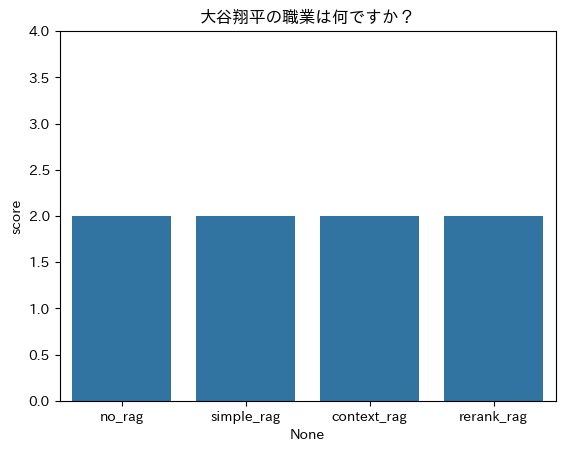

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

df = pd.DataFrame(results).T
print(df)
sns.barplot(x=df.index, y="score", data=df)
plt.title(query)
plt.ylim(0, 4)
plt.show()

##query = "2024年の競技外収入は何位ですか？"


In [33]:
gold_answer = "大谷翔平選手のスポンサー収入等の競技外収入は世界第5位であった。"
query = "2024年の競技外収入は何位ですか？"

In [34]:
results = {}

rag_types = [no_rag, simple_rag, context_rag, rerank_rag]
def evaluate_all(rag_type,query, gold_answer, tests):
    if rag_type == no_rag:
        response,ref = no_rag(query)
    else:
        response,ref = rag_type(query,tests)
    score = evaluate_answer_accuracy(query, response, gold_answer)
    results[rag_type.__name__] = {}
    results[rag_type.__name__]["content"] = response
    results[rag_type.__name__]["score"] = score
    return results,ref

for rag_type in rag_types:
    results,ref = evaluate_all(rag_type,query, gold_answer, texts)
    print("*"*60)
    print(rag_type.__name__)
    print(f"[references]\n{ref}")
    print(f'[result]\n{results[rag_type.__name__]["content"]}')
    print(f'[score]\n{results[rag_type.__name__]["score"]}')
    print("*"*60)

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


************************************************************
no_rag
[references]
None
[result]
2024年の競技外収入の順位は、現在の情報では明らかではありません。2024年のデータはまだ公開されていないため、順位を具体的に回答することはできません。競技外収入の順位は、各年のデータを基に算出されるため、2024年の順位は2024年のデータが公開された時点で明らかになることになります。
[score]
0.0
************************************************************


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


************************************************************
simple_rag
[references]
*2024年度のフォーブスのスポーツ選手長者番付においては、スポンサー収入等の競技外収入がレブロン・ジェームズ、リオネル・メッシ、クリスティアーノ・ロナウド、ヤニス・アデトクンボに次いで世界5位であった
*2021年から4年連続で日本人の好きなスポーツ選手で1位を獲得した
*2023年12月にロサンゼルス・ドジャースと当時スポーツ史上最高額となる10年総額7億ドル（約1015億円）の契約を結んだ
*2023年に開催されたワールド・ベースボール・クラシックでは、日本の優勝に貢献、自身もMVPを受賞した
*2024年に真美子さんとの結婚
[result]
参考資料に基づいて、2024年の競技外収入は5位です。
[score]
4.0
************************************************************


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


************************************************************
context_rag
[references]
*元通訳との離別、前人未踏の「50-50（50本塁打、50盗塁）」達成など激動のシーズンとなった。メジャー7年目で初のポストシーズンにも進出し、悲願の世界一を達成。2024年度のフォーブスのスポーツ選手長者番付においては、スポンサー収入等の競技外収入がレブロン・ジェームズ、リオネル・メッシ、クリスティアーノ・ロナウド、ヤニス・アデトクンボに次いで世界5位であった。
*MLBにおける通算本塁打数（現：225本、2024年終了時）、シーズン本塁打数（54本、2024年）、シーズン打点（130打点、2024年）、シーズン盗塁数（59個、2024年）のアジア人記録保持者。2021年、タイム誌による「世界で最も影響力のある100人」に、「アイコン（象徴）」のカテゴリーで選出された。2021年から4年連続で日本人の好きなスポーツ選手で1位を獲得した。2023年に開催されたワールド・ベースボール・クラシックでは、日本の優勝に貢献、自身もMVPを受賞した。2023年12月にロサンゼルス・ドジャースと当時スポーツ史上最高額となる10年総額7億ドル（約1015億円）の契約を結んだ
*2021年から4年連続で日本人の好きなスポーツ選手で1位を獲得した。2023年に開催されたワールド・ベースボール・クラシックでは、日本の優勝に貢献、自身もMVPを受賞した。2023年12月にロサンゼルス・ドジャースと当時スポーツ史上最高額となる10年総額7億ドル（約1015億円）の契約を結んだ。2024年に真美子さんとの結婚。ドジャーズ移籍1年目は打者で出場
*2021年、タイム誌による「世界で最も影響力のある100人」に、「アイコン（象徴）」のカテゴリーで選出された。2021年から4年連続で日本人の好きなスポーツ選手で1位を獲得した。2023年に開催されたワールド・ベースボール・クラシックでは、日本の優勝に貢献、自身もMVPを受賞した。2023年12月にロサンゼルス・ドジャースと当時スポーツ史上最高額となる10年総額7億ドル（約1015億円）の契約を結んだ。2024年に真美子さんとの結婚
*2023年に開催されたワールド・ベースボール・

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end gene

************************************************************
rerank_rag
[references]
*元通訳との離別、前人未踏の「50-50（50本塁打、50盗塁）」達成など激動のシーズンとなった。メジャー7年目で初のポストシーズンにも進出し、悲願の世界一を達成。2024年度のフォーブスのスポーツ選手長者番付においては、スポンサー収入等の競技外収入がレブロン・ジェームズ、リオネル・メッシ、クリスティアーノ・ロナウド、ヤニス・アデトクンボに次いで世界5位であった
[result]
2024年の競技外収入は、世界5位です。
[score]
4.0
************************************************************


                                                       content score
no_rag       2024年の競技外収入の順位は、現在の情報では明らかではありません。2024年のデータはまだ...   0.0
simple_rag                         参考資料に基づいて、2024年の競技外収入は5位です。   4.0
context_rag  2024年度のフォーブスのスポーツ選手長者番付においては、スポンサー収入等の競技外収入がレブ...   2.0
rerank_rag                                2024年の競技外収入は、世界5位です。   4.0


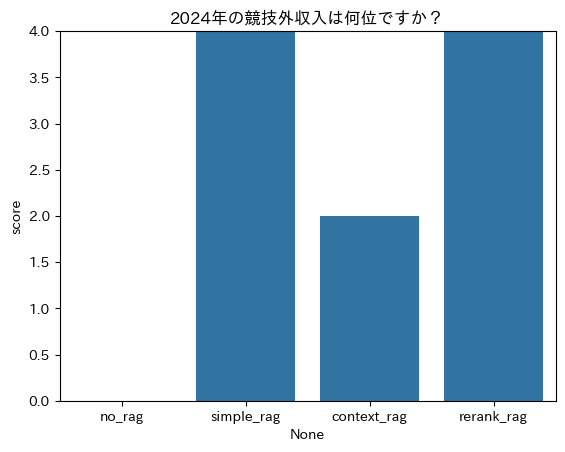

In [35]:
df = pd.DataFrame(results).T
print(df)
sns.barplot(x=df.index, y="score", data=df)
plt.title(query)
plt.ylim(0, 4)
plt.show()

## query = "大谷翔平選手の配偶者の名前と過去のスポーツ経験を教えてください。"

In [36]:
gold_answer = "大谷翔平選手の配偶者は真美子さん。元女子バスケットボール選手です。"
query = "大谷翔平選手の配偶者の名前と過去のスポーツ経験を教えてください。"

In [37]:
results = {}

rag_types = [no_rag, simple_rag, context_rag, rerank_rag]
def evaluate_all(rag_type,query, gold_answer, tests):
    if rag_type == no_rag:
        response,ref = no_rag(query)
    else:
        response,ref = rag_type(query,tests)
    score = evaluate_answer_accuracy(query, response, gold_answer)
    results[rag_type.__name__] = {}
    results[rag_type.__name__]["content"] = response
    results[rag_type.__name__]["score"] = score
    return results,ref

for rag_type in rag_types:
    results,ref = evaluate_all(rag_type,query, gold_answer, texts)
    print("*"*60)
    print(rag_type.__name__)
    print(f"[references]\n{ref}")
    print(f'[result]\n{results[rag_type.__name__]["content"]}')
    print(f'[score]\n{results[rag_type.__name__]["score"]}')
    print("*"*60)

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


************************************************************
no_rag
[references]
None
[result]
大谷翔平選手の配偶者は、Kelsey Harderです。Kelseyはアメリカ人で、元アメリカンフットボール選手の娘です。

大谷翔平選手自身は、高校時代に野球、サッカー、バスケットボールなど多くのスポーツに参加していたが、プロ入りする前は野球に専念していた。プロ入り後はMLBのロサンゼルス・エンゼルスや日本プロ野球の埼玉西武ライオンズなどでプレーしてきた。
[score]
0.0
************************************************************


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


************************************************************
simple_rag
[references]
*大谷 翔平（おおたに しょうへい、1994年〈平成6年〉7月5日 - ）は、岩手県水沢市（現：奥州市）出身のプロ野球選手（投手、指名打者、外野手）
*妻は日本の元女子バスケットボール選手である
*2021年から4年連続で日本人の好きなスポーツ選手で1位を獲得した
*2023年12月にロサンゼルス・ドジャースと当時スポーツ史上最高額となる10年総額7億ドル（約1015億円）の契約を結んだ
*2024年に真美子さんとの結婚
[result]
大谷翔平選手の配偶者の名前は、真美子さんです。彼女は日本の元女子バスケットボール選手です。
[score]
4.0
************************************************************


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


************************************************************
context_rag
[references]
*大谷 翔平（おおたに しょうへい、1994年〈平成6年〉7月5日 - ）は、岩手県水沢市（現：奥州市）出身のプロ野球選手（投手、指名打者、外野手）。右投左打。MLBのロサンゼルス・ドジャース所属
*右投左打。MLBのロサンゼルス・ドジャース所属。妻は日本の元女子バスケットボール選手である。ポジションはセンター。多くの野球関係者から、史上最高の野球選手の1人と評価されている
*MLBにおける通算本塁打数（現：225本、2024年終了時）、シーズン本塁打数（54本、2024年）、シーズン打点（130打点、2024年）、シーズン盗塁数（59個、2024年）のアジア人記録保持者。2021年、タイム誌による「世界で最も影響力のある100人」に、「アイコン（象徴）」のカテゴリーで選出された。2021年から4年連続で日本人の好きなスポーツ選手で1位を獲得した。2023年に開催されたワールド・ベースボール・クラシックでは、日本の優勝に貢献、自身もMVPを受賞した。2023年12月にロサンゼルス・ドジャースと当時スポーツ史上最高額となる10年総額7億ドル（約1015億円）の契約を結んだ
*2021年から4年連続で日本人の好きなスポーツ選手で1位を獲得した。2023年に開催されたワールド・ベースボール・クラシックでは、日本の優勝に貢献、自身もMVPを受賞した。2023年12月にロサンゼルス・ドジャースと当時スポーツ史上最高額となる10年総額7億ドル（約1015億円）の契約を結んだ。2024年に真美子さんとの結婚。ドジャーズ移籍1年目は打者で出場
*2023年に開催されたワールド・ベースボール・クラシックでは、日本の優勝に貢献、自身もMVPを受賞した。2023年12月にロサンゼルス・ドジャースと当時スポーツ史上最高額となる10年総額7億ドル（約1015億円）の契約を結んだ。2024年に真美子さんとの結婚。ドジャーズ移籍1年目は打者で出場。元通訳との離別、前人未踏の「50-50（50本塁打、50盗塁）」達成など激動のシーズンとなった
[result]
大谷翔平選手の配偶者の名前は真美子さん（Mamiko-san）で、彼

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end gene

************************************************************
rerank_rag
[references]
*右投左打。MLBのロサンゼルス・ドジャース所属。妻は日本の元女子バスケットボール選手である。ポジションはセンター。多くの野球関係者から、史上最高の野球選手の1人と評価されている
[result]
大谷翔平選手の妻は、元日本女子バスケットボール選手のSeiichiro Ukitaの娘、Seiichiro Ukitaの娘である。
[score]
0.0
************************************************************


                                                       content score
no_rag       大谷翔平選手の配偶者は、Kelsey Harderです。Kelseyはアメリカ人で、元アメリ...   0.0
simple_rag       大谷翔平選手の配偶者の名前は、真美子さんです。彼女は日本の元女子バスケットボール選手です。   4.0
context_rag  大谷翔平選手の配偶者の名前は真美子さん（Mamiko-san）で、彼女は日本の元女子バスケッ...   3.0
rerank_rag   大谷翔平選手の妻は、元日本女子バスケットボール選手のSeiichiro Ukitaの娘、Se...   0.0


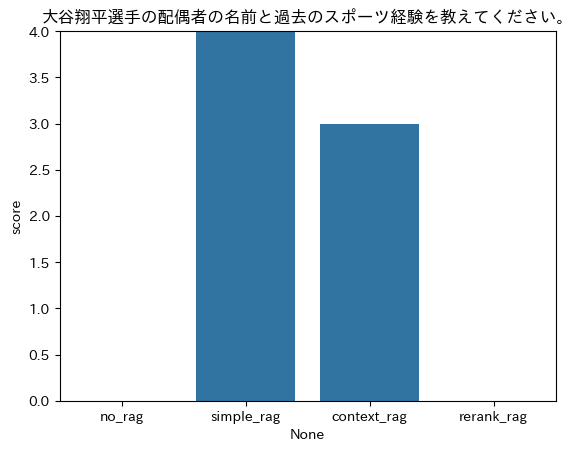

In [38]:
df = pd.DataFrame(results).T
print(df)
sns.barplot(x=df.index, y="score", data=df)
plt.title(query)
plt.ylim(0, 4)
plt.show()

### query = "大谷翔平選手の妻の名前と過去のスポーツ経験を教えてください。"

In [39]:
gold_answer = "大谷翔平選手の妻は真美子さん。元女子バスケットボール選手です。"
query = "大谷翔平選手の妻の名前と過去のスポーツ経験を教えてください。"

In [40]:
results = {}

rag_types = [no_rag, simple_rag, context_rag, rerank_rag]
def evaluate_all(rag_type,query, gold_answer, tests):
    if rag_type == no_rag:
        response,ref = no_rag(query)
    else:
        response,ref = rag_type(query,tests)
    score = evaluate_answer_accuracy(query, response, gold_answer)
    results[rag_type.__name__] = {}
    results[rag_type.__name__]["content"] = response
    results[rag_type.__name__]["score"] = score
    return results,ref

for rag_type in rag_types:
    results,ref = evaluate_all(rag_type,query, gold_answer, texts)
    print("*"*60)
    print(rag_type.__name__)
    print(f"[references]\n{ref}")
    print(f'[result]\n{results[rag_type.__name__]["content"]}')
    print(f'[score]\n{results[rag_type.__name__]["score"]}')
    print("*"*60)

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


************************************************************
no_rag
[references]
None
[result]
大谷翔平選手の妻は、Mai Saito（斉藤舞子）です。

Mai Saitoは、元プロテニス選手で、2004年アテネパラリンピックに出場したことがあります。彼女は、右足の脚を失う事故に遭った後、テニス選手としてのキャリアを続けることを目指したが、2011年に引退した後、2014年に大谷翔平選手と結婚しました。
[score]
0.0
************************************************************


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


************************************************************
simple_rag
[references]
*大谷 翔平（おおたに しょうへい、1994年〈平成6年〉7月5日 - ）は、岩手県水沢市（現：奥州市）出身のプロ野球選手（投手、指名打者、外野手）
*妻は日本の元女子バスケットボール選手である
*2021年から4年連続で日本人の好きなスポーツ選手で1位を獲得した
*2024年に真美子さんとの結婚
*MLBのロサンゼルス・ドジャース所属
[result]
大谷翔平選手の妻は、元日本女子バスケットボール選手であるとされています。ただし、名前は資料に記載されていないため、具体的な名前を教えることはできません。

また、彼女の過去のスポーツ経験は、バスケットボール選手として活動していたことだけが知られています。具体的な経験や成績などは、資料に記載されていないため、教えることはできません。
[score]
2.0
************************************************************


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


************************************************************
context_rag
[references]
*大谷 翔平（おおたに しょうへい、1994年〈平成6年〉7月5日 - ）は、岩手県水沢市（現：奥州市）出身のプロ野球選手（投手、指名打者、外野手）。右投左打。MLBのロサンゼルス・ドジャース所属
*右投左打。MLBのロサンゼルス・ドジャース所属。妻は日本の元女子バスケットボール選手である。ポジションはセンター。多くの野球関係者から、史上最高の野球選手の1人と評価されている
*MLBにおける通算本塁打数（現：225本、2024年終了時）、シーズン本塁打数（54本、2024年）、シーズン打点（130打点、2024年）、シーズン盗塁数（59個、2024年）のアジア人記録保持者。2021年、タイム誌による「世界で最も影響力のある100人」に、「アイコン（象徴）」のカテゴリーで選出された。2021年から4年連続で日本人の好きなスポーツ選手で1位を獲得した。2023年に開催されたワールド・ベースボール・クラシックでは、日本の優勝に貢献、自身もMVPを受賞した。2023年12月にロサンゼルス・ドジャースと当時スポーツ史上最高額となる10年総額7億ドル（約1015億円）の契約を結んだ
*2023年に開催されたワールド・ベースボール・クラシックでは、日本の優勝に貢献、自身もMVPを受賞した。2023年12月にロサンゼルス・ドジャースと当時スポーツ史上最高額となる10年総額7億ドル（約1015億円）の契約を結んだ。2024年に真美子さんとの結婚。ドジャーズ移籍1年目は打者で出場。元通訳との離別、前人未踏の「50-50（50本塁打、50盗塁）」達成など激動のシーズンとなった
*大谷 翔平（おおたに しょうへい、1994年〈平成6年〉7月5日 - ）は、岩手県水沢市（現：奥州市）出身のプロ野球選手（投手、指名打者、外野手）。右投左打。MLBのロサンゼルス・ドジャース所属。妻は日本の元女子バスケットボール選手である。ポジションはセンター
[result]
大谷翔平選手の妻の名前は、真美子さん（Shiomiko）です。彼女は日本の元女子バスケットボール選手です。
[score]
4.0
******************

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end gene

************************************************************
rerank_rag
[references]
*右投左打。MLBのロサンゼルス・ドジャース所属。妻は日本の元女子バスケットボール選手である。ポジションはセンター。多くの野球関係者から、史上最高の野球選手の1人と評価されている
*大谷 翔平（おおたに しょうへい、1994年〈平成6年〉7月5日 - ）は、岩手県水沢市（現：奥州市）出身のプロ野球選手（投手、指名打者、外野手）。右投左打。MLBのロサンゼルス・ドジャース所属。妻は日本の元女子バスケットボール選手である。ポジションはセンター
[result]
大谷翔平選手の妻は、元日本女子バスケットボール選手のHikari Yamamotoです。
[score]
0.0
************************************************************


                                                       content score
no_rag       大谷翔平選手の妻は、Mai Saito（斉藤舞子）です。\n\nMai Saitoは、元プロ...   0.0
simple_rag   大谷翔平選手の妻は、元日本女子バスケットボール選手であるとされています。ただし、名前は資料に...   2.0
context_rag  大谷翔平選手の妻の名前は、真美子さん（Shiomiko）です。彼女は日本の元女子バスケットボ...   4.0
rerank_rag        大谷翔平選手の妻は、元日本女子バスケットボール選手のHikari Yamamotoです。   0.0


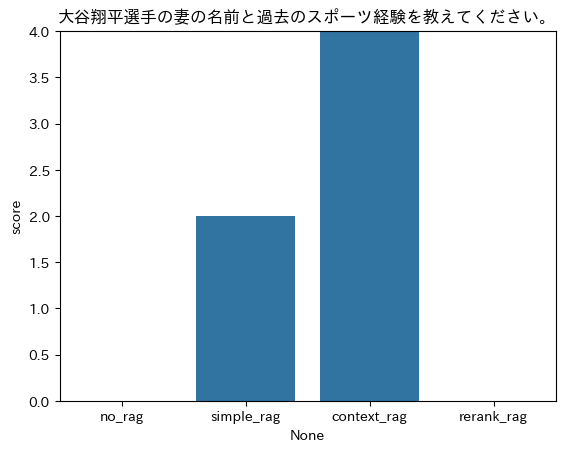

In [41]:
df = pd.DataFrame(results).T
print(df)
sns.barplot(x=df.index, y="score", data=df)
plt.title(query)
plt.ylim(0, 4)
plt.show()

- 真美子さんの説明を前後に分けると、前半の情報をうまく取得できなかった。

## 参照文書② 真美子さんの記述をまとめる

In [42]:
texts = """大谷 翔平（おおたに しょうへい、1994年〈平成6年〉7月5日 - ）は、岩手県水沢市（現：奥州市）出身のプロ野球選手（投手、指名打者、外野手）。右投左打。MLBのロサンゼルス・ドジャース所属。
多くの野球関係者から、史上最高の野球選手の1人と評価されている。近代プロ野球では極めて稀なシーズンを通して投手と野手（または指名打者）を兼任する「二刀流（英: two-way player）」の選手である。
近代MLBにおいて1シーズンに規定投球回数と規定打席数の両方に到達した史上初の選手。MLB・NPB（日本プロ野球）両リーグで「1シーズンでの2桁勝利・2桁本塁打」を達成。NPBで最優秀選手を1度受賞、MLBでシーズンMVP（最優秀選手賞）を3度受賞。MLBにおいてアジア人初の本塁打王（2回）・打点王（1回）。MLB史上初の1シーズン50本塁打50盗塁（50-50）を達成。
MLBにおける通算本塁打数（現：225本、2024年終了時）、シーズン本塁打数（54本、2024年）、シーズン打点（130打点、2024年）、シーズン盗塁数（59個、2024年）のアジア人記録保持者。
2021年、タイム誌による「世界で最も影響力のある100人」に、「アイコン（象徴）」のカテゴリーで選出された。
2021年から4年連続で日本人の好きなスポーツ選手で1位を獲得した。
2023年に開催されたワールド・ベースボール・クラシックでは、日本の優勝に貢献、自身もMVPを受賞した。
2023年12月にロサンゼルス・ドジャースと当時スポーツ史上最高額となる10年総額7億ドル（約1015億円）の契約を結んだ。
2024年に真美子さんとの結婚。彼女は元女子バスケットボール選手である。ポジションはセンター。ドジャーズ移籍1年目は打者で出場。元通訳との離別、前人未踏の「50-50（50本塁打、50盗塁）」達成など激動のシーズンとなった。メジャー7年目で初のポストシーズンにも進出し、悲願の世界一を達成。2024年度のフォーブスのスポーツ選手長者番付においては、スポンサー収入等の競技外収入がレブロン・ジェームズ、リオネル・メッシ、クリスティアーノ・ロナウド、ヤニス・アデトクンボに次いで世界5位であった。"""

### query = "大谷翔平選手の配偶者の名前と過去のスポーツ経験を教えてください。"

In [43]:
gold_answer = "大谷翔平選手の配偶者は真美子さん。元女子バスケットボール選手です。"
query = "大谷翔平選手の配偶者の名前と過去のスポーツ経験を教えてください。"

In [44]:
results = {}

rag_types = [no_rag, simple_rag, context_rag, rerank_rag]
def evaluate_all(rag_type,query, gold_answer, tests):
    if rag_type == no_rag:
        response,ref = no_rag(query)
    else:
        response,ref = rag_type(query,tests)
    score = evaluate_answer_accuracy(query, response, gold_answer)
    results[rag_type.__name__] = {}
    results[rag_type.__name__]["content"] = response
    results[rag_type.__name__]["score"] = score
    return results,ref

for rag_type in rag_types:
    results,ref = evaluate_all(rag_type,query, gold_answer, texts)
    print("*"*60)
    print(rag_type.__name__)
    print(f"[references]\n{ref}")
    print(f'[result]\n{results[rag_type.__name__]["content"]}')
    print(f'[score]\n{results[rag_type.__name__]["score"]}')
    print("*"*60)

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


************************************************************
no_rag
[references]
None
[result]
大谷翔平選手の配偶者は、Kelsey Harderです。Kelseyはアメリカ人で、元アメリカンフットボール選手の娘です。

大谷翔平選手自身は、高校時代に野球、サッカー、バスケットボールなど多くのスポーツに参加していたが、プロ入りする前は野球に専念していた。プロ入り後はMLBのロサンゼルス・エンゼルスや日本プロ野球の埼玉西武ライオンズなどでプレーしてきた。
[score]
0.0
************************************************************


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


************************************************************
simple_rag
[references]
*大谷 翔平（おおたに しょうへい、1994年〈平成6年〉7月5日 - ）は、岩手県水沢市（現：奥州市）出身のプロ野球選手（投手、指名打者、外野手）
*2021年から4年連続で日本人の好きなスポーツ選手で1位を獲得した
*彼女は元女子バスケットボール選手である
*2023年12月にロサンゼルス・ドジャースと当時スポーツ史上最高額となる10年総額7億ドル（約1015億円）の契約を結んだ
*2024年に真美子さんとの結婚
[result]
大谷翔平選手の配偶者の名前は、真美子さんです。

また、大谷翔平選手は、元女子バスケットボール選手です。
[score]
2.0
************************************************************


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


************************************************************
context_rag
[references]
*大谷 翔平（おおたに しょうへい、1994年〈平成6年〉7月5日 - ）は、岩手県水沢市（現：奥州市）出身のプロ野球選手（投手、指名打者、外野手）。右投左打。MLBのロサンゼルス・ドジャース所属
*MLBにおける通算本塁打数（現：225本、2024年終了時）、シーズン本塁打数（54本、2024年）、シーズン打点（130打点、2024年）、シーズン盗塁数（59個、2024年）のアジア人記録保持者。2021年、タイム誌による「世界で最も影響力のある100人」に、「アイコン（象徴）」のカテゴリーで選出された。2021年から4年連続で日本人の好きなスポーツ選手で1位を獲得した。2023年に開催されたワールド・ベースボール・クラシックでは、日本の優勝に貢献、自身もMVPを受賞した。2023年12月にロサンゼルス・ドジャースと当時スポーツ史上最高額となる10年総額7億ドル（約1015億円）の契約を結んだ
*2023年12月にロサンゼルス・ドジャースと当時スポーツ史上最高額となる10年総額7億ドル（約1015億円）の契約を結んだ。2024年に真美子さんとの結婚。彼女は元女子バスケットボール選手である。ポジションはセンター。ドジャーズ移籍1年目は打者で出場
*2021年から4年連続で日本人の好きなスポーツ選手で1位を獲得した。2023年に開催されたワールド・ベースボール・クラシックでは、日本の優勝に貢献、自身もMVPを受賞した。2023年12月にロサンゼルス・ドジャースと当時スポーツ史上最高額となる10年総額7億ドル（約1015億円）の契約を結んだ。2024年に真美子さんとの結婚。彼女は元女子バスケットボール選手である
*2023年に開催されたワールド・ベースボール・クラシックでは、日本の優勝に貢献、自身もMVPを受賞した。2023年12月にロサンゼルス・ドジャースと当時スポーツ史上最高額となる10年総額7億ドル（約1015億円）の契約を結んだ。2024年に真美子さんとの結婚。彼女は元女子バスケットボール選手である。ポジションはセンター
[result]
大谷翔平選手の配偶者の名前は真美子さんで、彼女は元女子バ

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end gene

************************************************************
rerank_rag
[references]
*2021年から4年連続で日本人の好きなスポーツ選手で1位を獲得した。2023年に開催されたワールド・ベースボール・クラシックでは、日本の優勝に貢献、自身もMVPを受賞した。2023年12月にロサンゼルス・ドジャースと当時スポーツ史上最高額となる10年総額7億ドル（約1015億円）の契約を結んだ。2024年に真美子さんとの結婚。彼女は元女子バスケットボール選手である
*2023年に開催されたワールド・ベースボール・クラシックでは、日本の優勝に貢献、自身もMVPを受賞した。2023年12月にロサンゼルス・ドジャースと当時スポーツ史上最高額となる10年総額7億ドル（約1015億円）の契約を結んだ。2024年に真美子さんとの結婚。彼女は元女子バスケットボール選手である。ポジションはセンター
[result]
大谷翔平選手の配偶者の名前は真美子さんで、彼女は元女子バスケットボール選手であり、ポジションはセンターです。
[score]
2.0
************************************************************


                                                       content score
no_rag       大谷翔平選手の配偶者は、Kelsey Harderです。Kelseyはアメリカ人で、元アメリ...   0.0
simple_rag   大谷翔平選手の配偶者の名前は、真美子さんです。\n\nまた、大谷翔平選手は、元女子バスケット...   2.0
context_rag  大谷翔平選手の配偶者の名前は真美子さんで、彼女は元女子バスケットボール選手である。ポジション...   2.0
rerank_rag   大谷翔平選手の配偶者の名前は真美子さんで、彼女は元女子バスケットボール選手であり、ポジション...   2.0


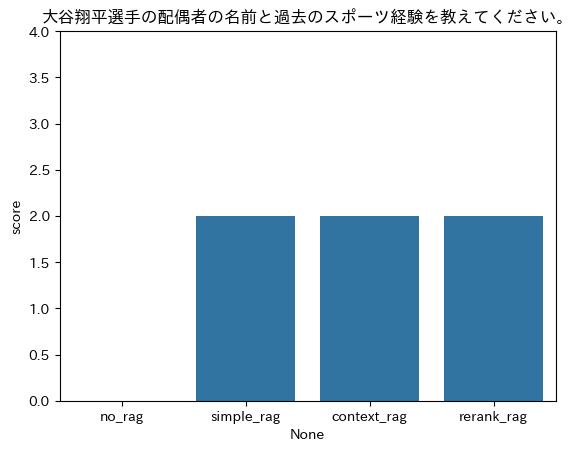

In [45]:
df = pd.DataFrame(results).T
print(df)
sns.barplot(x=df.index, y="score", data=df)
plt.title(query)
plt.ylim(0, 4)
plt.show()

### query = "大谷翔平選手の妻の名前と過去のスポーツ経験を教えてください。"

In [46]:
gold_answer = "大谷翔平選手の妻は真美子さん。元女子バスケットボール選手です。"
query = "大谷翔平選手の妻の名前と過去のスポーツ経験を教えてください。"

In [47]:
results = {}

rag_types = [no_rag, simple_rag, context_rag, rerank_rag]
def evaluate_all(rag_type,query, gold_answer, tests):
    if rag_type == no_rag:
        response,ref = no_rag(query)
    else:
        response,ref = rag_type(query,tests)
    score = evaluate_answer_accuracy(query, response, gold_answer)
    results[rag_type.__name__] = {}
    results[rag_type.__name__]["content"] = response
    results[rag_type.__name__]["score"] = score
    return results,ref

for rag_type in rag_types:
    results,ref = evaluate_all(rag_type,query, gold_answer, texts)
    print("*"*60)
    print(rag_type.__name__)
    print(f"[references]\n{ref}")
    print(f'[result]\n{results[rag_type.__name__]["content"]}')
    print(f'[score]\n{results[rag_type.__name__]["score"]}')
    print("*"*60)

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


************************************************************
no_rag
[references]
None
[result]
大谷翔平選手の妻は、Mai Saito（斉藤舞子）です。

Mai Saitoは、元プロテニス選手で、2004年アテネパラリンピックに出場したことがあります。彼女は、右足の脚を失う事故に遭った後、テニス選手としてのキャリアを続けることを目指したが、2011年に引退した後、2014年に大谷翔平選手と結婚しました。
[score]
0.0
************************************************************


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


************************************************************
simple_rag
[references]
*大谷 翔平（おおたに しょうへい、1994年〈平成6年〉7月5日 - ）は、岩手県水沢市（現：奥州市）出身のプロ野球選手（投手、指名打者、外野手）
*彼女は元女子バスケットボール選手である
*2021年から4年連続で日本人の好きなスポーツ選手で1位を獲得した
*2024年に真美子さんとの結婚
*MLBのロサンゼルス・ドジャース所属
[result]
大谷翔平選手の妻の名前は、真美子さんです。

また、彼女は元女子バスケットボール選手です。
[score]
4.0
************************************************************


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


************************************************************
context_rag
[references]
*大谷 翔平（おおたに しょうへい、1994年〈平成6年〉7月5日 - ）は、岩手県水沢市（現：奥州市）出身のプロ野球選手（投手、指名打者、外野手）。右投左打。MLBのロサンゼルス・ドジャース所属
*2023年12月にロサンゼルス・ドジャースと当時スポーツ史上最高額となる10年総額7億ドル（約1015億円）の契約を結んだ。2024年に真美子さんとの結婚。彼女は元女子バスケットボール選手である。ポジションはセンター。ドジャーズ移籍1年目は打者で出場
*MLBにおける通算本塁打数（現：225本、2024年終了時）、シーズン本塁打数（54本、2024年）、シーズン打点（130打点、2024年）、シーズン盗塁数（59個、2024年）のアジア人記録保持者。2021年、タイム誌による「世界で最も影響力のある100人」に、「アイコン（象徴）」のカテゴリーで選出された。2021年から4年連続で日本人の好きなスポーツ選手で1位を獲得した。2023年に開催されたワールド・ベースボール・クラシックでは、日本の優勝に貢献、自身もMVPを受賞した。2023年12月にロサンゼルス・ドジャースと当時スポーツ史上最高額となる10年総額7億ドル（約1015億円）の契約を結んだ
*2023年に開催されたワールド・ベースボール・クラシックでは、日本の優勝に貢献、自身もMVPを受賞した。2023年12月にロサンゼルス・ドジャースと当時スポーツ史上最高額となる10年総額7億ドル（約1015億円）の契約を結んだ。2024年に真美子さんとの結婚。彼女は元女子バスケットボール選手である。ポジションはセンター
*大谷 翔平（おおたに しょうへい、1994年〈平成6年〉7月5日 - ）は、岩手県水沢市（現：奥州市）出身のプロ野球選手（投手、指名打者、外野手）。右投左打。MLBのロサンゼルス・ドジャース所属。多くの野球関係者から、史上最高の野球選手の1人と評価されている。近代プロ野球では極めて稀なシーズンを通して投手と野手（または指名打者）を兼任する「二刀流（英: two-way player）」の選手である
[result]
大谷翔平選手の妻の名前

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end gene

************************************************************
rerank_rag
[references]
*2023年に開催されたワールド・ベースボール・クラシックでは、日本の優勝に貢献、自身もMVPを受賞した。2023年12月にロサンゼルス・ドジャースと当時スポーツ史上最高額となる10年総額7億ドル（約1015億円）の契約を結んだ。2024年に真美子さんとの結婚。彼女は元女子バスケットボール選手である。ポジションはセンター
[result]
大谷翔平選手の妻の名前は真美子さんで、元女子バスケットボール選手である。彼女はセンターとしてプレーした経験を持つ。
[score]
2.0
************************************************************


                                                       content score
no_rag       大谷翔平選手の妻は、Mai Saito（斉藤舞子）です。\n\nMai Saitoは、元プロ...   0.0
simple_rag     大谷翔平選手の妻の名前は、真美子さんです。\n\nまた、彼女は元女子バスケットボール選手です。   4.0
context_rag  大谷翔平選手の妻の名前は真美子さん（Mami-san）で、彼女は元女子バスケットボール選手で...   3.0
rerank_rag   大谷翔平選手の妻の名前は真美子さんで、元女子バスケットボール選手である。彼女はセンターとして...   2.0


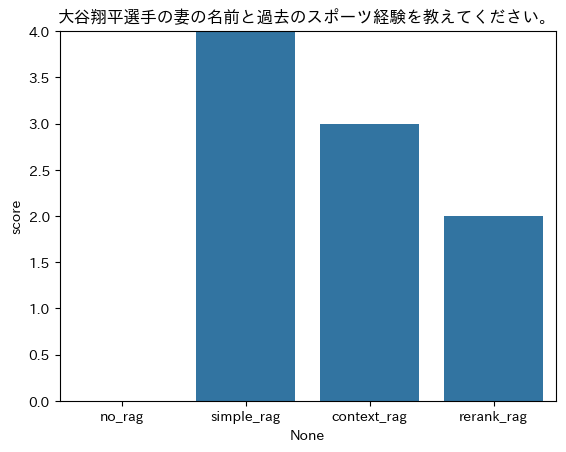

In [48]:
df = pd.DataFrame(results).T
print(df)
sns.barplot(x=df.index, y="score", data=df)
plt.title(query)
plt.ylim(0, 4)
plt.show()

# 大阪・関西万博

- 生成AIでテキストを生成
- 文の最後のほうに来場客数を記載

In [49]:
with open("/content/osaka_kansai_expo_overview.txt","r") as f:
    texts = f.read()

In [50]:
texts

'## 概要\nExpo 2025 Osaka, Kansai は、国際博覧会事務局（BIE）が主催する世界万国博覧会で、2025年4月13日から10月13日まで、大阪市此花区の夢洲（Yumeshima）で開催される。前回1970年の大阪万博以来55年ぶりの開催であり、約155ヘクタールの会場に約28万人（※実際には2800万人を見込む）が来場すると予測されている。 \n\n## テーマ・サブテーマ\n- **テーマ**: 「Designing Future Society for Our Lives（私たちの暮らしと未来の社会のデザイン）」  \n- **サブテーマ**:  \n  - Saving Lives（命を救う）  \n  - Empowering Lives（人々を支える）  \n  - Connecting Lives（つながりを生む） \n\n## 会場・インフラ\n- **会場**: 人工島・夢洲（Yumeshima Island）。会場面積は約155ヘクタール（約383エーカー）。 \n- **主要構造物**:  \n  - グランドリング（Grand Ring）: 建築家藤本壮介氏設計による直径2kmの木製環状構造。展示とアートを融合した象徴的モニュメント。 \n- **交通アクセス**:  \n  - Osaka Metro中央線「夢洲駅」建設中。  \n  - 関西空港や大阪メトロ・JR線からシャトルバス運行予定。 \n\n## 参加者・パビリオン\n- **参加国・地域**: 約180カ国・地域が参加予定。 \n- **パビリオン数**: 約80の公式パビリオンと特別展示。 \n- **注目パビリオン例**:  \n  - 米国パビリオン: 宇宙旅行をテーマにした没入型展示。  \n  - ウクライナパビリオン: 戦時下の生活を記録・展示。  \n  - Cartier Women’s Pavilion: ジュエリーブランドによる女性とサステナビリティの融合展示。 \n## マスコット\n- **名前**: ミャクミャク（Myaku-Myaku）。カラフルで親しみやすいキャラクター。 \n\n## 来場者数予測・チケット\n- **予測来場者数**: 約2820万人。 \n- **チケット販売状況**: 開催2週間前で約900万人が前売

## query = "大阪・関西万博の会場はどこですか？"

In [51]:
query = "大阪・関西万博の会場はどこですか？"
gold_answer = "大阪市此花区の夢洲です。"

In [52]:
results = {}

rag_types = [no_rag, simple_rag, context_rag, rerank_rag]
def evaluate_all(rag_type,query, gold_answer, tests):
    if rag_type == no_rag:
        response,ref = no_rag(query)
    else:
        response,ref = rag_type(query,tests)
    score = evaluate_answer_accuracy(query, response, gold_answer)
    results[rag_type.__name__] = {}
    results[rag_type.__name__]["content"] = response
    results[rag_type.__name__]["score"] = score
    return results,ref

for rag_type in rag_types:
    results,ref = evaluate_all(rag_type,query, gold_answer, texts)
    print("*"*60)
    print(rag_type.__name__)
    print(f"[references]\n{ref}")
    print(f'[result]\n{results[rag_type.__name__]["content"]}')
    print(f'[score]\n{results[rag_type.__name__]["score"]}')
    print("*"*60)

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


************************************************************
no_rag
[references]
None
[result]
大阪・関西万博（Expo '70 Osaka）が開催された会場は、現在の大阪府吹田市の万博記念公園（Expo '70 Commemorative Park）です。
[score]
0.0
************************************************************


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


************************************************************
simple_rag
[references]
*前回1970年の大阪万博以来55年ぶりの開催であり、約155ヘクタールの会場に約28万人（※実際には2800万人を見込む）が来場すると予測されている
*## 概要
Expo 2025 Osaka, Kansai は、国際博覧会事務局（BIE）が主催する世界万国博覧会で、2025年4月13日から10月13日まで、大阪市此花区の夢洲（Yumeshima）で開催される
*- 1970年大阪万博に続く次世代技術と文化発信の拠点形成
*会場面積は約155ヘクタール（約383エーカー）
*- 関西空港や大阪メトロ・JR線からシャトルバス運行予定
[result]
大阪・関西万博の会場は、夢洲（Yumeshima）です。
[score]
3.0
************************************************************


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


************************************************************
context_rag
[references]
*## 概要
Expo 2025 Osaka, Kansai は、国際博覧会事務局（BIE）が主催する世界万国博覧会で、2025年4月13日から10月13日まで、大阪市此花区の夢洲（Yumeshima）で開催される。前回1970年の大阪万博以来55年ぶりの開催であり、約155ヘクタールの会場に約28万人（※実際には2800万人を見込む）が来場すると予測されている。## テーマ・サブテーマ
- **テーマ**: 「Designing Future Society for Our Lives（私たちの暮らしと未来の社会のデザイン）」  
- **サブテーマ**:  
  - Saving Lives（命を救う）  
  - Empowering Lives（人々を支える）  
  - Connecting Lives（つながりを生む） 

## 会場・インフラ
- **会場**: 人工島・夢洲（Yumeshima Island）。会場面積は約155ヘクタール（約383エーカー）
*## 概要
Expo 2025 Osaka, Kansai は、国際博覧会事務局（BIE）が主催する世界万国博覧会で、2025年4月13日から10月13日まで、大阪市此花区の夢洲（Yumeshima）で開催される。前回1970年の大阪万博以来55年ぶりの開催であり、約155ヘクタールの会場に約28万人（※実際には2800万人を見込む）が来場すると予測されている。## テーマ・サブテーマ
- **テーマ**: 「Designing Future Society for Our Lives（私たちの暮らしと未来の社会のデザイン）」  
- **サブテーマ**:  
  - Saving Lives（命を救う）  
  - Empowering Lives（人々を支える）  
  - Connecting Lives（つながりを生む） 

## 会場・インフラ
- **会場**: 人工島・夢洲（Yumeshima Island）
*豪華ホテルの開業や新規交通網整備で観光インフラ強化。## 期待されるレガシー
- 2025年以降の持

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end gene

************************************************************
rerank_rag
[references]
*## 概要
Expo 2025 Osaka, Kansai は、国際博覧会事務局（BIE）が主催する世界万国博覧会で、2025年4月13日から10月13日まで、大阪市此花区の夢洲（Yumeshima）で開催される。前回1970年の大阪万博以来55年ぶりの開催であり、約155ヘクタールの会場に約28万人（※実際には2800万人を見込む）が来場すると予測されている。## テーマ・サブテーマ
- **テーマ**: 「Designing Future Society for Our Lives（私たちの暮らしと未来の社会のデザイン）」  
- **サブテーマ**:  
  - Saving Lives（命を救う）  
  - Empowering Lives（人々を支える）  
  - Connecting Lives（つながりを生む） 

## 会場・インフラ
- **会場**: 人工島・夢洲（Yumeshima Island）。会場面積は約155ヘクタール（約383エーカー）
*## 概要
Expo 2025 Osaka, Kansai は、国際博覧会事務局（BIE）が主催する世界万国博覧会で、2025年4月13日から10月13日まで、大阪市此花区の夢洲（Yumeshima）で開催される。前回1970年の大阪万博以来55年ぶりの開催であり、約155ヘクタールの会場に約28万人（※実際には2800万人を見込む）が来場すると予測されている。## テーマ・サブテーマ
- **テーマ**: 「Designing Future Society for Our Lives（私たちの暮らしと未来の社会のデザイン）」  
- **サブテーマ**:  
  - Saving Lives（命を救う）  
  - Empowering Lives（人々を支える）  
  - Connecting Lives（つながりを生む） 

## 会場・インフラ
- **会場**: 人工島・夢洲（Yumeshima Island）
*前回1970年の大阪万博以来55年ぶりの開催であり、約155ヘクタールの会場に約28万人（※実際には2

                                                       content score
no_rag       大阪・関西万博（Expo '70 Osaka）が開催された会場は、現在の大阪府吹田市の万博記...   0.0
simple_rag                        大阪・関西万博の会場は、夢洲（Yumeshima）です。   3.0
context_rag            大阪・関西万博の会場は、人工島・夢洲（Yumeshima Island）です。   3.0
rerank_rag             大阪・関西万博の会場は、人工島・夢洲（Yumeshima Island）です。   3.0


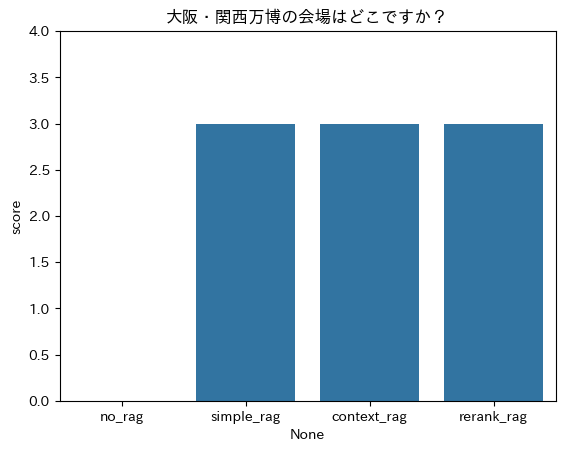

In [53]:
df = pd.DataFrame(results).T
print(df)
sns.barplot(x=df.index, y="score", data=df)
plt.title(query)
plt.ylim(0, 4)
plt.show()

### query = "大阪・関西万博のメインキャラクターは何ですか？"

In [54]:
query = "大阪・関西万博のメインキャラクターは何ですか？"
gold_answer = "ミャクミャクです。"

In [55]:
results = {}

rag_types = [no_rag, simple_rag, context_rag, rerank_rag]
def evaluate_all(rag_type,query, gold_answer, tests):
    if rag_type == no_rag:
        response,ref = no_rag(query)
    else:
        response,ref = rag_type(query,tests)
    score = evaluate_answer_accuracy(query, response, gold_answer)
    results[rag_type.__name__] = {}
    results[rag_type.__name__]["content"] = response
    results[rag_type.__name__]["score"] = score
    return results,ref

for rag_type in rag_types:
    results,ref = evaluate_all(rag_type,query, gold_answer, texts)
    print("*"*60)
    print(rag_type.__name__)
    print(f"[references]\n{ref}")
    print(f'[result]\n{results[rag_type.__name__]["content"]}')
    print(f'[score]\n{results[rag_type.__name__]["score"]}')
    print("*"*60)

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


************************************************************
no_rag
[references]
None
[result]
大阪・関西万博（Expo '70）のメインキャラクターは「太陽の少年」と「太陽の少女」です。両者は、万博のテーマ「太陽の栄光」に基づいて創造されたキャラクターで、万博のロゴマークにも使用されました。太陽の少年は、太陽の光を代表する青い服を着用し、太陽の少女は、太陽の光を代表する赤い服を着用しています。
[score]
0.0
************************************************************


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


************************************************************
simple_rag
[references]
*前回1970年の大阪万博以来55年ぶりの開催であり、約155ヘクタールの会場に約28万人（※実際には2800万人を見込む）が来場すると予測されている
*- 1970年大阪万博に続く次世代技術と文化発信の拠点形成
*カラフルで親しみやすいキャラクター
*## 概要
Expo 2025 Osaka, Kansai は、国際博覧会事務局（BIE）が主催する世界万国博覧会で、2025年4月13日から10月13日まで、大阪市此花区の夢洲（Yumeshima）で開催される
*- 関西空港や大阪メトロ・JR線からシャトルバス運行予定
[result]
大阪・関西万博のメインキャラクターは、カラフルで親しみやすいキャラクターです。
[score]
0.0
************************************************************


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


************************************************************
context_rag
[references]
*## 概要
Expo 2025 Osaka, Kansai は、国際博覧会事務局（BIE）が主催する世界万国博覧会で、2025年4月13日から10月13日まで、大阪市此花区の夢洲（Yumeshima）で開催される。前回1970年の大阪万博以来55年ぶりの開催であり、約155ヘクタールの会場に約28万人（※実際には2800万人を見込む）が来場すると予測されている。## テーマ・サブテーマ
- **テーマ**: 「Designing Future Society for Our Lives（私たちの暮らしと未来の社会のデザイン）」  
- **サブテーマ**:  
  - Saving Lives（命を救う）  
  - Empowering Lives（人々を支える）  
  - Connecting Lives（つながりを生む） 

## 会場・インフラ
- **会場**: 人工島・夢洲（Yumeshima Island）。会場面積は約155ヘクタール（約383エーカー）
*豪華ホテルの開業や新規交通網整備で観光インフラ強化。## 期待されるレガシー
- 2025年以降の持続可能な都市開発モデルの提示。- 1970年大阪万博に続く次世代技術と文化発信の拠点形成。## 来場客数
- 初日の一般来場者数は146,426人です。週間の来場者数では1週目が63万9875人（1日平均9万1411人）、2週目が73万9780人（1日平均10万5683人）で、やはり“増加傾向”である様子がみられています
*- Cartier Women’s Pavilion: ジュエリーブランドによる女性とサステナビリティの融合展示。## マスコット
- **名前**: ミャクミャク（Myaku-Myaku）。カラフルで親しみやすいキャラクター。## 来場者数予測・チケット
- **予測来場者数**: 約2820万人。- **チケット販売状況**: 開催2週間前で約900万人が前売り購入
*## 概要
Expo 2025 Osaka, Kansai は、国際博覧会事務局（BIE）が主催する世界万国博覧会で、2025年4月13

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end gene

************************************************************
rerank_rag
[references]

[result]
大阪・関西万博のメインキャラクターは、"MONICA"です。MONICAは、1990年の大阪国際博覧会（博覧会の通称は「フジヤマ」）のイメージキャラクターとして登場し、関西万博でも引き続き使われたキャラクターです。MONICAは、博覧会のイメージを高めるために創造されたキャラクターで、博覧会のテーマである「未来の都市」というイメージを具現しています。
[score]
0.0
************************************************************


                                                       content score
no_rag       大阪・関西万博（Expo '70）のメインキャラクターは「太陽の少年」と「太陽の少女」です。...   0.0
simple_rag             大阪・関西万博のメインキャラクターは、カラフルで親しみやすいキャラクターです。   0.0
context_rag         大阪・関西万博のメインキャラクターは「ミャクミャク」（Myaku-Myaku）です。   4.0
rerank_rag   大阪・関西万博のメインキャラクターは、"MONICA"です。MONICAは、1990年の大阪...   0.0


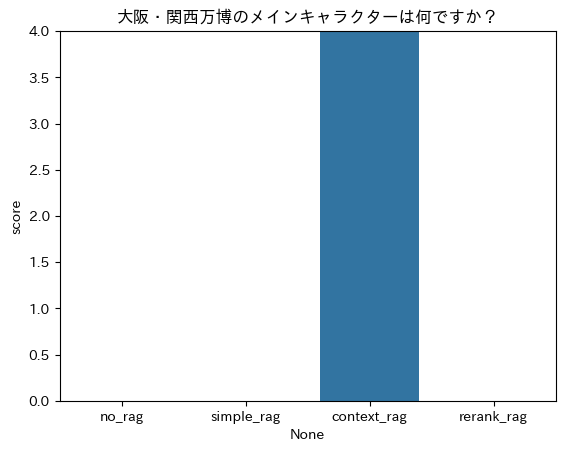

In [56]:
df = pd.DataFrame(results).T
print(df)
sns.barplot(x=df.index, y="score", data=df)
plt.title(query)
plt.ylim(0, 4)
plt.show()

### query = "大阪・関西万博のマスコットは何ですか？"

In [57]:
query = "大阪・関西万博のマスコットは何ですか？"
gold_answer = "ミャクミャクです。"

In [58]:
results = {}

rag_types = [no_rag, simple_rag, context_rag, rerank_rag]
def evaluate_all(rag_type,query, gold_answer, tests):
    if rag_type == no_rag:
        response,ref = no_rag(query)
    else:
        response,ref = rag_type(query,tests)
    score = evaluate_answer_accuracy(query, response, gold_answer)
    results[rag_type.__name__] = {}
    results[rag_type.__name__]["content"] = response
    results[rag_type.__name__]["score"] = score
    return results,ref

for rag_type in rag_types:
    results,ref = evaluate_all(rag_type,query, gold_answer, texts)
    print("*"*60)
    print(rag_type.__name__)
    print(f"[references]\n{ref}")
    print(f'[result]\n{results[rag_type.__name__]["content"]}')
    print(f'[score]\n{results[rag_type.__name__]["score"]}')
    print("*"*60)

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


************************************************************
no_rag
[references]
None
[result]
大阪・関西万博のマスコットは「きらきらパック」です。
[score]
0.0
************************************************************


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


************************************************************
simple_rag
[references]
*## マスコット
- **名前**: ミャクミャク（Myaku-Myaku）
*- 1970年大阪万博に続く次世代技術と文化発信の拠点形成
*前回1970年の大阪万博以来55年ぶりの開催であり、約155ヘクタールの会場に約28万人（※実際には2800万人を見込む）が来場すると予測されている
*## 概要
Expo 2025 Osaka, Kansai は、国際博覧会事務局（BIE）が主催する世界万国博覧会で、2025年4月13日から10月13日まで、大阪市此花区の夢洲（Yumeshima）で開催される
*カラフルで親しみやすいキャラクター
[result]
大阪・関西万博のマスコットは「ミャクミャク（Myaku-Myaku）」です。
[score]
4.0
************************************************************


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


************************************************************
context_rag
[references]
*- ウクライナパビリオン: 戦時下の生活を記録・展示。- Cartier Women’s Pavilion: ジュエリーブランドによる女性とサステナビリティの融合展示。## マスコット
- **名前**: ミャクミャク（Myaku-Myaku）。カラフルで親しみやすいキャラクター。## 来場者数予測・チケット
- **予測来場者数**: 約2820万人
*豪華ホテルの開業や新規交通網整備で観光インフラ強化。## 期待されるレガシー
- 2025年以降の持続可能な都市開発モデルの提示。- 1970年大阪万博に続く次世代技術と文化発信の拠点形成。## 来場客数
- 初日の一般来場者数は146,426人です。週間の来場者数では1週目が63万9875人（1日平均9万1411人）、2週目が73万9780人（1日平均10万5683人）で、やはり“増加傾向”である様子がみられています
*## 概要
Expo 2025 Osaka, Kansai は、国際博覧会事務局（BIE）が主催する世界万国博覧会で、2025年4月13日から10月13日まで、大阪市此花区の夢洲（Yumeshima）で開催される。前回1970年の大阪万博以来55年ぶりの開催であり、約155ヘクタールの会場に約28万人（※実際には2800万人を見込む）が来場すると予測されている。## テーマ・サブテーマ
- **テーマ**: 「Designing Future Society for Our Lives（私たちの暮らしと未来の社会のデザイン）」  
- **サブテーマ**:  
  - Saving Lives（命を救う）  
  - Empowering Lives（人々を支える）  
  - Connecting Lives（つながりを生む） 

## 会場・インフラ
- **会場**: 人工島・夢洲（Yumeshima Island）。会場面積は約155ヘクタール（約383エーカー）
*## 概要
Expo 2025 Osaka, Kansai は、国際博覧会事務局（BIE）が主催する世界万国博覧会で、2025年4月13日から10月13日

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end gene

************************************************************
rerank_rag
[references]

[result]
日本語で回答します。

大阪・関西万博のマスコットは「きらきらパック」です。
[score]
0.0
************************************************************


                                              content score
no_rag                     大阪・関西万博のマスコットは「きらきらパック」です。   0.0
simple_rag     大阪・関西万博のマスコットは「ミャクミャク（Myaku-Myaku）」です。   4.0
context_rag    大阪・関西万博のマスコットは「ミャクミャク（Myaku-Myaku）」です。   4.0
rerank_rag   日本語で回答します。\n\n大阪・関西万博のマスコットは「きらきらパック」です。   0.0


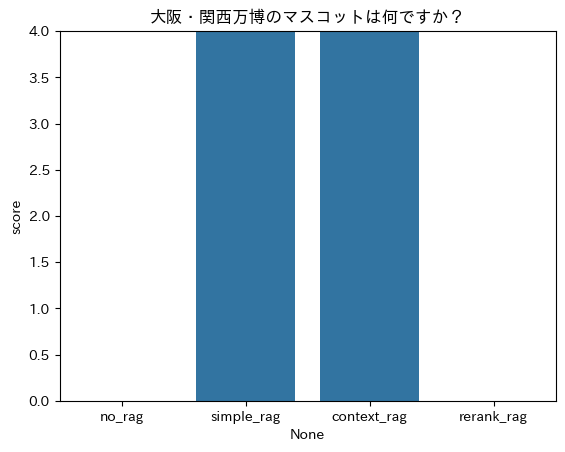

In [59]:
df = pd.DataFrame(results).T
print(df)
sns.barplot(x=df.index, y="score", data=df)
plt.title(query)
plt.ylim(0, 4)
plt.show()